# Analysing a portfolio of assets based in UK energy and financial markets with investment recommendations

This project evaluates a diversified investment portfolio consisting of UK energy and financial stocks (BP, Shell, HSBC, Barclays), ETFs (FTSE 100, S&P 500), and UK 10-year government bonds. Historical price data and macroeconomic indicators, including GDP, commodity prices were collected, cleaned, and queried using SQL for filtering.

### Package Imports

In [1]:
from dotenv import load_dotenv
import yfinance as yf
import pandas as pd
from fredapi import Fred
import pandasql as ps
from pandasql import sqldf
import requests
import statistics
import math
import numpy as np
import os

### Data Extraction

In [4]:
# UK Energy Markeys
bp = yf.Ticker('BP')
shell = yf.Ticker('SHEL')

# UK Financial Markets
hsbc = yf.Ticker('HSBC')
barclays = yf.Ticker('BARC.L')

# UK / Global ETFs
ftse_100 = yf.Ticker('^FTSE')
s_and_p_500 = yf.Ticker('^GSPC')

# UK 10 Year Gilt Government Bond
load_dotenv()
fred_api_key = os.getenv('FRED_API_KEY')
fred = Fred(fred_api_key)

bond_yield_data = fred.get_series('IRLTLT01GBM156N')

# UK Unemployment
uk_unemployment = fred.get_series('LRUNTTTTGBQ156S')

# UK Consumer Price Index (CPI)
uk_cpi = fred.get_series('GBRCPIALLMINMEI')

# UK Gross Domestic Product (GDP)
gdp_url = 'https://api.worldbank.org/v2/country/GBR/indicator/NY.GDP.MKTP.CD?format=json'
gdp_response = requests.get(gdp_url).json()

# Crude Oil Prices
crude_oil = fred.get_series('GBRCPIALLMINMEI', observation_start='2015-01-01', observation_end='2025-01-01')

### Data Processing

In [5]:
# UK Energy Markeys
bp_history = pd.DataFrame(bp.history(period='max'))
shell_history = pd.DataFrame(shell.history(period='max'))

# UK Financial Markets
hsbc_history = pd.DataFrame(hsbc.history(period='max'))
barclays_history = pd.DataFrame(barclays.history(period='max'))

# UK / Global ETFs
ftse_100_history = pd.DataFrame(ftse_100.history(period='max'))
s_and_p_500_history = pd.DataFrame(s_and_p_500.history(period='max'))

# UK 10 Year Gilt Government Bond
government_bond = pd.DataFrame(bond_yield_data, columns=["Yield"])
government_bond.index.name = "Date"

# UK Unemployment
uk_unemployment = pd.DataFrame(uk_unemployment, columns=["Unemployment"])
uk_unemployment.index.name = "Date"

# UK Consumer Price Index (CPI)
uk_cpi = pd.DataFrame(uk_cpi, columns=["CPI"])

# UK Gross Domestic Product (GDP)
gdp_data = gdp_response[1]
gdp_data = pd.DataFrame(gdp_data)
gdp_data = gdp_data[['date', 'value']].rename(columns={'date': 'Year', 'value': 'GDP_USD'})
gdp_data['Year'] = gdp_data['Year'].astype(int)

# Crude Oil Prices
oil_data = pd.DataFrame(crude_oil)
oil_data.index = pd.to_datetime(oil_data.index)
oil_data.columns = ['WTI Crude Oil Price (USD/barrel)']

### Portfolio Calculations



*   Daily return per asset

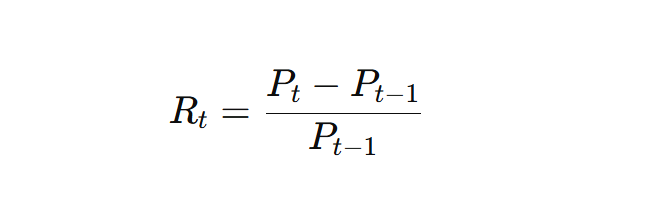


In [ ]:
print(f"BP Historical Stock Prices\n {bp_history}")
print(f"Shell Historical Stock Prices\n {bp_history}")

In [8]:
def daily_returns_list(stock, start_date, end_date):
    """
    Calculate daily returns for a stock between start_date and end_date.

    stock: pandas DataFrame with 'Date' and 'Close' columns
    start_date, end_date: strings in 'YYYY-MM-DD' format
    """
    # SQL query to get previous day close and current day close
    temp = ps.sqldf(f"""
        SELECT
            Date(Date) AS Date,
            Close AS close_price,
            LAG(Close, 1) OVER (ORDER BY Date) AS previous_price
        FROM {stock}
        WHERE Date BETWEEN '{start_date}' AND '{end_date}'
    """)

    # Drop the first row (since it has no previous_price)
    temp = temp.dropna(subset=['previous_price'])

    # Compute daily returns
    temp['daily_return'] = (temp['close_price'] - temp['previous_price']) / temp['previous_price']

    # Convert to list
    return temp['daily_return'].tolist()


In [9]:
def daily_return_gov_bonds():

  temp = (ps.sqldf(f"""

  SELECT
    Date(Date) as 'date',
    Yield as yield,
    LAG(Yield, 1) OVER (ORDER BY Date) as previous_yield
  FROM
    government_bond
  WHERE Date > '2025-06-01'

  """))

  r_t = 0
  p_t = temp.loc[1, 'yield']

  p_t_prev = temp.loc[1, 'previous_yield']


  r_t = (p_t - p_t_prev) / p_t_prev

  return r_t

In [10]:
def portfolio_average_daily_return(stock_dfs, weights, start_date, end_date):
    # Get daily returns for each stock
    daily_returns_lists = [daily_returns_list(stock, start_date, end_date) for stock in stock_dfs]

    # Combine weighted daily returns
    portfolio_daily_returns = [
        sum(weight * ret for weight, ret in zip(weights, daily_returns))
        for daily_returns in zip(*daily_returns_lists)
    ]

    # Return average daily return
    return sum(portfolio_daily_returns) / len(portfolio_daily_returns)

In [11]:
def portfolio_volatility(stock_dfs, weights, start_date, end_date):
    """
    Calculate annualised portfolio volatility.

    stock_dfs: list of pandas DataFrames, each with 'Date' and 'Close' columns
    weights: list of weights corresponding to each stock
    start_date, end_date: strings 'YYYY-MM-DD'
    """
    all_daily_returns = []

    for stock in stock_dfs:
        daily_returns = daily_returns_list(stock, start_date, end_date)  # uses your daily_returns_list function
        all_daily_returns.append(daily_returns)

    # Combine daily returns using weights
    portfolio_daily_returns = [
        sum(ret * w for ret, w in zip(day_returns, weights))
        for day_returns in zip(*all_daily_returns)
    ]

    # Compute annualised volatility
    volatility = statistics.stdev(portfolio_daily_returns) * math.sqrt(252)

    return volatility


In [12]:
def portfolio_cumulative_return(stock_dfs, weights, start_date, end_date):
    daily_returns_lists = [daily_returns_list(stock, start_date, end_date) for stock in stock_dfs]
    portfolio_daily_returns = [
        sum(ret * w for ret, w in zip(day_returns, weights))
        for day_returns in zip(*daily_returns_lists)
    ]
    cum_return = 1
    for r in portfolio_daily_returns:
        cum_return *= (1 + r)
    return cum_return - 1

In [13]:
def portfolio_sharpe_ratio(stock_dfs, weights, start_date, end_date, risk_free_rate=0.0):
    avg_daily = portfolio_average_daily_return(stock_dfs, weights, start_date, end_date)
    vol = portfolio_volatility(stock_dfs, weights, start_date, end_date)
    # Annualised Sharpe ratio
    return (avg_daily * 252 - risk_free_rate) / vol

In [14]:
def portfolio_max_drawdown(stock_dfs, weights, start_date, end_date):
    daily_returns_lists = [daily_returns_list(stock, start_date, end_date) for stock in stock_dfs]
    portfolio_daily_returns = [
        sum(ret * w for ret, w in zip(day_returns, weights))
        for day_returns in zip(*daily_returns_lists)
    ]
    cum_returns = []
    cum = 1
    for r in portfolio_daily_returns:
        cum *= (1 + r)
        cum_returns.append(cum)
    peak = cum_returns[0]
    max_dd = 0
    for x in cum_returns:
        if x > peak:
            peak = x
        drawdown = (peak - x) / peak
        if drawdown > max_dd:
            max_dd = drawdown
    return max_dd

In [15]:
def benchmark_average_daily_return(stock_df, start_date, end_date):
    """
    Calculate the average daily return of a single stock/index using SQL on a Pandas DataFrame.

    stock_df: pandas DataFrame with date as the index and 'Close' column
    start_date, end_date: strings in 'YYYY-MM-DD' format
    """
    # Ensure the index is a column for SQL queries
    stock_df = stock_df.reset_index().rename(columns={'index': 'Date'})
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])

    # Define SQL query
    query = f"""
    WITH daily_returns AS (
        SELECT
            Date,
            Close,
            LAG(Close) OVER (ORDER BY Date) AS previous_close
        FROM stock_df
        WHERE Date BETWEEN '{start_date}' AND '{end_date}'
    )
    SELECT AVG((Close - previous_close) / previous_close) AS avg_daily_return
    FROM daily_returns
    WHERE previous_close IS NOT NULL
    """

    # Run SQL query on the DataFrame
    result = ps.sqldf(query, locals())

    return result['avg_daily_return'][0]

In [16]:
def fast_portfolio_timeseries(stock_dfs, weights, start_date, end_date, benchmark_df):
    import pandas as pd
    import numpy as np
    from functools import reduce

    # Prepare all stock DataFrames: keep 'Close', rename columns
    processed_dfs = []
    for i, df in enumerate(stock_dfs):
        temp = df[['Close']].copy()
        temp.columns = [f'Stock{i}']
        # Ensure datetime index is UTC
        if temp.index.tz is not None:
            temp = temp.tz_convert('UTC')
        else:
            temp = temp.tz_localize('UTC')
        processed_dfs.append(temp)

    # Merge all stock DataFrames on datetime index
    prices = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), processed_dfs)

    # Filter by date range and fill missing values
    prices = prices[(prices.index >= start_date) & (prices.index <= end_date)]
    prices = prices.ffill().bfill()  # forward/backward-fill missing data

    # Compute daily returns and portfolio returns
    returns = prices.pct_change().fillna(0)
    port_returns = returns.dot(weights)

    # Portfolio metrics
    cum_return = (1 + port_returns).cumprod() - 1
    vol = port_returns.expanding().std()
    avg_return = port_returns.expanding().mean()
    sharpe = avg_return / vol
    running_max = cum_return.cummax()
    drawdown = (cum_return - running_max) / running_max
    max_dd = drawdown.cummin()

    # Align benchmark
    benchmark_aligned = benchmark_df[['Close']].copy()
    if benchmark_aligned.index.tz is not None:
        benchmark_aligned = benchmark_aligned.tz_convert('UTC')
    else:
        benchmark_aligned = benchmark_aligned.tz_localize('UTC')
    benchmark_aligned = benchmark_aligned[(benchmark_aligned.index >= start_date) & (benchmark_aligned.index <= end_date)]
    benchmark_aligned = benchmark_aligned.reindex(prices.index).ffill().bfill()
    benchmark_returns = benchmark_aligned.pct_change().fillna(0)

    # Compile metrics DataFrame
    metrics_df = pd.DataFrame({
        'AvgDailyReturn': avg_return,
        'Volatility': vol,
        'CumulativeReturn': cum_return,
        'Sharpe': sharpe,
        'MaxDrawdown': max_dd,
        'BenchmarkDailyReturn': benchmark_returns['Close']
    }, index=prices.index)

    return metrics_df


### Portfolio Weights Simulation

- UK Financial Markets (HSBC, Barclays) - 30%
- UK Energy Markets (BP, Shell) - 20%
- FTSE 100 - 10%
- S&P 500 - 40%

In [17]:
stock_dfs = ['bp_history', 'shell_history', 'barclays_history', 'hsbc_history', 'ftse_100_history', 's_and_p_500_history']
benchmark = 's_and_d_500_history'
weights = [0.10, 0.10, 0.15, 0.15, 0.10, 0.40]

print(f"Average daily return: {portfolio_average_daily_return(stock_dfs, weights, '2025-01-01', '2025-08-19')*100:.2f}%")
print(f"Volatility: {portfolio_volatility(stock_dfs, weights, '2025-01-01', '2025-08-19')*100:.2f}%")
print(f"Cumulative return: {portfolio_cumulative_return(stock_dfs, weights, '2025-01-01', '2025-08-19')*100:.2f}%")
print(f"Sharpe ratio: {portfolio_sharpe_ratio(stock_dfs, weights, '2025-01-01', '2025-08-19'):.2f}")
print(f"Maximum drawdown: {portfolio_max_drawdown(stock_dfs, weights, '2025-01-01', '2025-08-19')*100:.2f}%")
print(f"S&P 500 daily return: {benchmark_average_daily_return(s_and_p_500_history, '2025-01-01', '2025-08-19')*100:.2f}%")

Average daily return: 0.13%
Volatility: 16.63%
Cumulative return: 21.19%
Sharpe ratio: 1.96
Maximum drawdown: 14.96%
S&P 500 daily return: 0.07%


In [18]:
stock_df = [bp_history, shell_history, barclays_history, hsbc_history, ftse_100_history, s_and_p_500_history]
# Example usage: make sure start <= end
portfolio_ts = fast_portfolio_timeseries(stock_df, weights, '2020-01-01', '2025-08-20', s_and_p_500_history)
print(portfolio_ts)


                           AvgDailyReturn  Volatility  CumulativeReturn  \
Date                                                                      
2020-01-02 00:00:00+00:00        0.000000         NaN          0.000000   
2020-01-02 05:00:00+00:00        0.000000    0.000000          0.000000   
2020-01-03 00:00:00+00:00       -0.000434    0.000751         -0.001301   
2020-01-03 05:00:00+00:00       -0.000963    0.001224         -0.003850   
2020-01-06 00:00:00+00:00       -0.001274    0.001267         -0.006356   
...                                   ...         ...               ...   
2025-08-17 23:00:00+00:00        0.000287    0.008085          1.053953   
2025-08-18 04:00:00+00:00        0.000286    0.008084          1.051512   
2025-08-18 23:00:00+00:00        0.000286    0.008083          1.052964   
2025-08-19 04:00:00+00:00        0.000285    0.008081          1.046161   
2025-08-19 23:00:00+00:00        0.000286    0.008080          1.048858   

                        

In [22]:
# Drop rows where BenchmarkDailyReturn is exactly zero
# metrics_clean = portfolio_ts[portfolio_ts['BenchmarkDailyReturn'] != 0]

# print(portfolio_ts)

# Save to CSV
# portfolio_ts.to_csv('portfolio_metrics.csv', index=True)

portfolio_ts_cleaned = portfolio_ts[portfolio_ts['BenchmarkDailyReturn'] != 0]
portfolio_ts_cleaned = portfolio_ts_cleaned.drop('MaxDrawdown', axis=1)

print(portfolio_ts_cleaned)

portfolio_ts_cleaned.to_csv('output-data/portfolio_metrics_cleaned.csv')



                           AvgDailyReturn  Volatility  CumulativeReturn  \
Date                                                                      
2020-01-03 05:00:00+00:00       -0.000963    0.001224         -0.003850   
2020-01-06 05:00:00+00:00       -0.000264    0.002720         -0.001604   
2020-01-07 05:00:00+00:00       -0.000504    0.002837         -0.004056   
2020-01-08 05:00:00+00:00       -0.000601    0.002510         -0.006023   
2020-01-09 05:00:00+00:00       -0.000089    0.002644         -0.001106   
...                                   ...         ...               ...   
2025-08-13 04:00:00+00:00        0.000288    0.008092          1.058392   
2025-08-14 04:00:00+00:00        0.000289    0.008089          1.065543   
2025-08-15 04:00:00+00:00        0.000287    0.008087          1.053489   
2025-08-18 04:00:00+00:00        0.000286    0.008084          1.051512   
2025-08-19 04:00:00+00:00        0.000285    0.008081          1.046161   

                        

In [ ]:
stock_dataframes = [shell_history, barclays_history, hsbc_history, ftse_100_history, s_and_p_500_history]
stock_names = ['Shell', 'Barclays', 'HSBC', 'FTSE_100', 'S_and_P_500']

for df, name in zip(stock_dataframes, stock_names):
    # Drop unwanted columns
    cleaned = df.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis=1, errors='ignore')

    # Ensure index is datetime
    cleaned.index = pd.to_datetime(cleaned.index)

    # Filter rows after 2020-01-01
    cleaned = cleaned[cleaned.index > '2020-01-01']

    # Save to CSV
    cleaned.to_csv(f'output-data/{name}_cleaned.csv')

government_bond.index = pd.to_datetime(government_bond.index)
government_bond = government_bond[government_bond.index > '2020-01-01']
government_bond.to_csv('output-data/cleaned_government_bond.csv')

uk_unemployment.index = pd.to_datetime(uk_unemployment.index)
uk_unemployment = uk_unemployment[uk_unemployment.index > '2020-01-01']
uk_unemployment.to_csv('output-data/uk_unemployment_cleaned.csv')

uk_cpi.index = pd.to_datetime(uk_cpi.index)
uk_cpi = uk_cpi[uk_cpi.index > '2020-01-01']
uk_cpi.index.name = 'Date'
uk_cpi.to_csv('output-data/uk_cpi_cleaned.csv')

gdp_data['Year'] = pd.to_datetime(gdp_data['Year'], format='%Y')
gdp_data = gdp_data[gdp_data['Year'] > '2018-01-01']
gdp_data.to_csv('output-data/uk_gdp_cleaned_usd.csv', index = False)


oil_data.index = pd.to_datetime(oil_data.index)
oil_data.index.name = 'Date'
oil_data = oil_data[oil_data.index > '2020-01-01']
oil_data.to_csv('output-data/crude_oil_data.csv')
